## Задание
У нас есть данные АА-теста с '2022-06-06' по '2022-06-12'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.
1. Построить гистограмму распределения получившихся 10000 p-values.
2. Посчитать, какой процент p values оказался меньше либо равен 0.05
3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

In [1]:
import pandahouse as ph
import seaborn as sns
import numpy as np
from scipy import stats

In [2]:

%matplotlib inline
rc = {
    'figure.figsize': (10, 6)
}
sns.set(rc=rc, style='whitegrid')

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220720'
}

In [4]:
query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-06-06' and '2022-06-12'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""
df = ph.read_clickhouse(query, connection=connection)

In [5]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


<AxesSubplot:xlabel='ctr', ylabel='Count'>

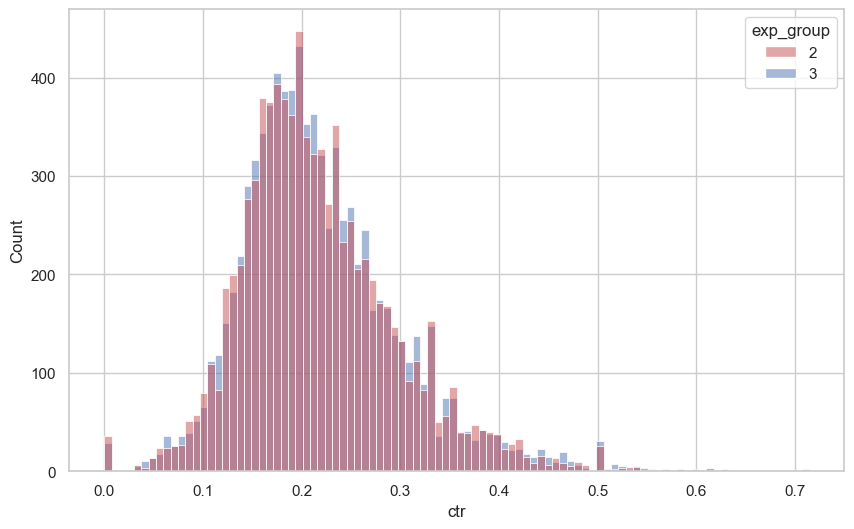

In [6]:
# распределение CTR групп 2 и 3

sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [7]:
# подсчёт p-value для каждой пары подвыборок

iterations = 10000
p_values = np.array([])
for i in range(iterations):
    p_value = stats.ttest_ind(df[df.exp_group == 2].ctr.sample(500),
                df[df.exp_group == 3].ctr.sample(500),
                equal_var=False).pvalue
    p_values = np.append(p_values, p_value)

Text(0, 0.5, 'frequency')

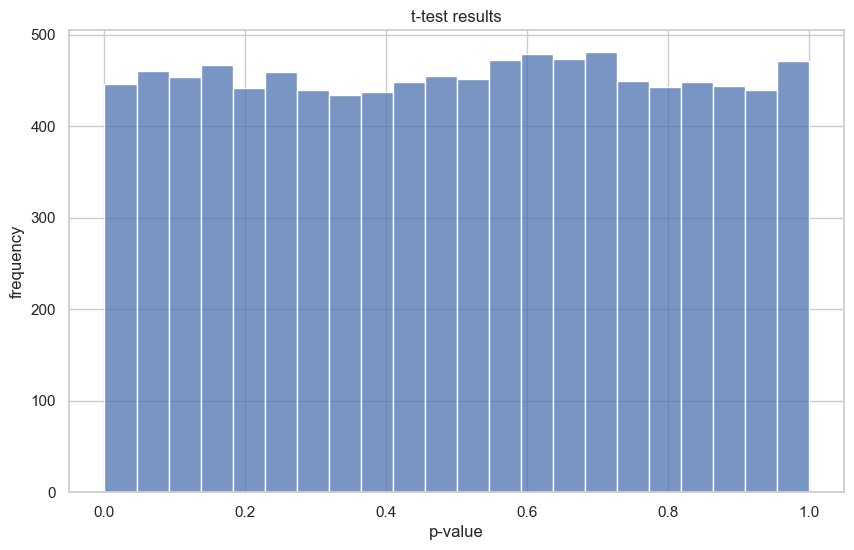

In [8]:
# распределение полученных p-value визуально похоже на равномерное

chart = sns.histplot(p_values)
chart.set_title('t-test results')
chart.set_xlabel('p-value')
chart.set_ylabel('frequency')

In [9]:
fp = np.count_nonzero(p_values <= 0.05)
print(f'Процент случаев, где на основе p-value можно принять альтернативную гипотезу о различии средних: {fp / len(p_values) * 100}%')

Процент случаев, где на основе p-value можно принять альтернативную гипотезу о различии средних: 5.0200000000000005%


Визуально CTR двух групп имеют +- одинаковое распределение. При проведении 10000 t-test (при a-уровне 0.05) примерно в 5% случаев тест показал статистически значимое различе CTR-ов. Исходя из этого можно принять гипотезу о том, что средние CTR в двух группах равны. То есть система сплитования работает корректно